In [ ]:
# Importing the necessary libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D, GlobalAvgPool2D, Dense, Add, Flatten, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.activations import relu
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from IPython.display import Image, display

# shush warnings
import logging
import tensorflow as tf

# Set logging level to only show errors
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Filter out warnings related to while_loop conversions
tf.get_logger().setLevel("ERROR")

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils

import zipfile
import scipy.io

from tensorflow import keras
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
# Miscellaneous
from tqdm import tqdm
import os
import pandas as pd
import random
from collections import Counter
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!gdown "https://drive.google.com/uc?id=1BNQdJotVpohNrJ-j-JG1F5LSPAjY7mo2"
!ls -l

Downloading...
From: https://drive.google.com/uc?id=1BNQdJotVpohNrJ-j-JG1F5LSPAjY7mo2
To: /content/archive.zip
100% 156M/156M [00:04<00:00, 37.5MB/s]
total 152144
-rw-r--r-- 1 root root 155791278 May 15 18:46 archive.zip
drwxr-xr-x 1 root root      4096 May 12 13:31 sample_data


In [ ]:
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    # Extract all files from the archive
    zip_ref.extractall()

In [ ]:
train_dir = '/content/Training/'
test_dir = '/content/Testing/'

In [ ]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
train_paths[:5]

['/content/Training/notumor/Tr-no_1247.jpg',
 '/content/Training/meningioma/Tr-me_0411.jpg',
 '/content/Training/meningioma/Tr-me_1150.jpg',
 '/content/Training/glioma/Tr-gl_0445.jpg',
 '/content/Training/notumor/Tr-no_1036.jpg']

In [ ]:
Counter(test_labels).keys()

dict_keys(['meningioma', 'pituitary', 'notumor', 'glioma'])

In [ ]:
Counter(test_labels).values()

dict_values([306, 300, 405, 300])

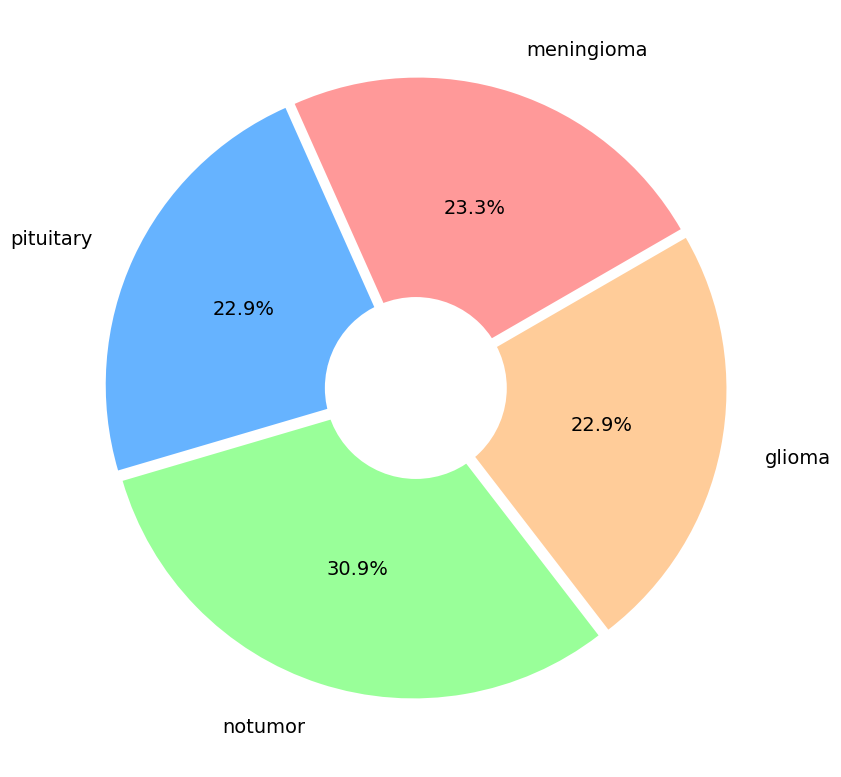

In [ ]:
plt.figure(figsize=(10,8))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.rcParams.update({'font.size': 14})
plt.pie(Counter(test_labels).values(), labels=Counter(test_labels).keys(),
         autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025), labeldistance=1.15, colors = colors,
        startangle=30)
centre_circle = plt.Circle((0,0),0.30,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# plt.title("Distribution of labels of brain tumor", y = 1.05, fontsize = 18)
plt.tight_layout()

# Data Argumentation

In [ ]:
# random augment of imput
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

In [ ]:
IMAGE_SIZE = 128
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

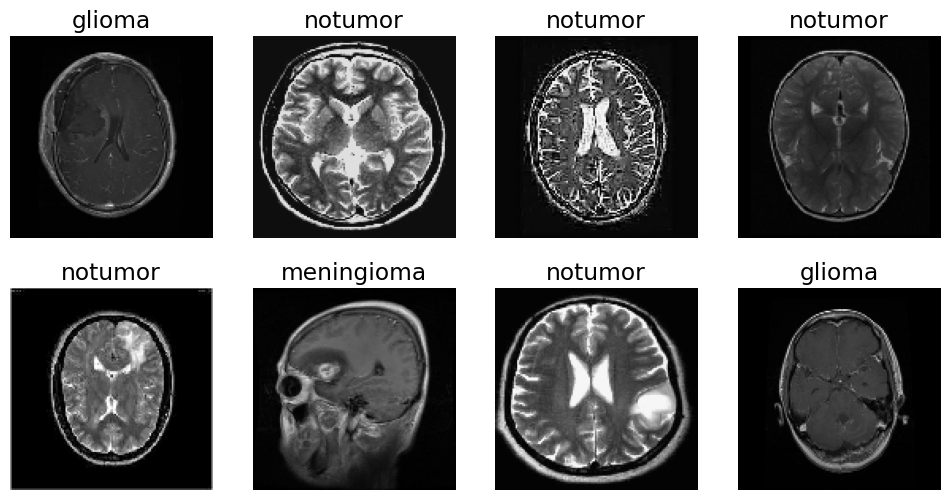

In [ ]:
images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
X_train = open_images(train_paths)
X_train.shape

(5712, 128, 128, 3)

In [ ]:
X_test = open_images(test_paths)
X_test.shape

(1311, 128, 128, 3)

In [ ]:
labels = sorted(set(train_labels))
print(labels)
label2idx = {l: i for i, l in enumerate(labels)}
idx2label = {i: l for i, l in enumerate(labels)}

['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
y_train = np.array([label2idx[label] for label in train_labels]).ravel()
y_test = np.array([label2idx[label] for label in test_labels]).ravel()

In [ ]:
# Split off 20% of train data for validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=109)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4569, 128, 128, 3), (1143, 128, 128, 3), (4569,), (1143,))

In [ ]:
datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
      # customize these and other parameters
      rotation_range=15,
      width_shift_range=1,
      height_shift_range=1,
      shear_range= 5,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest',
)

In [ ]:
X_train2 = X_train.copy()
X_train_more = X_train.copy()
y_train_more = y_train.copy()
datagen_aug.fit(X_train2)

for i in range(10):
    for x_batch, y_batch in datagen_aug.flow(X_train2, y_train, batch_size=128):
        X_train_more = np.append(X_train_more, x_batch.reshape(128, 128, 128, 3), axis = 0)
        y_train_more = np.append(y_train_more, y_batch)
        break
X_train_more.shape, y_train_more.shape

((5849, 128, 128, 3), (5849,))

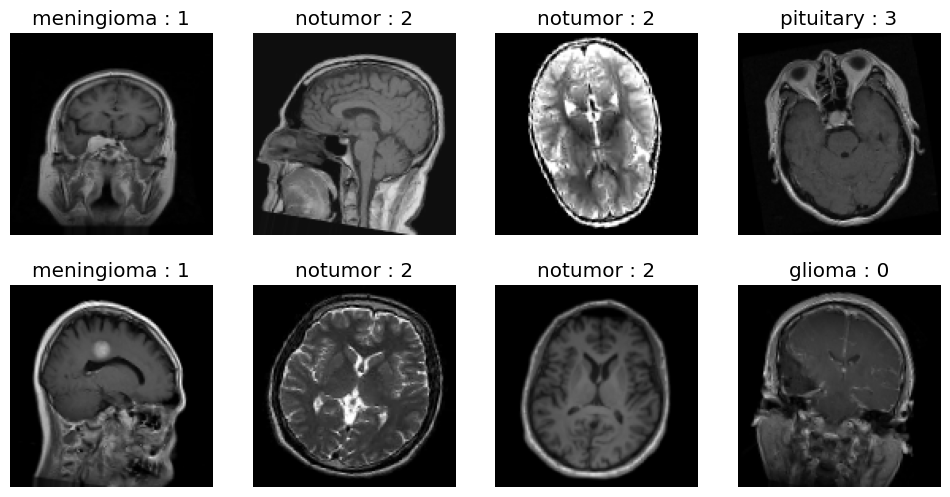

In [ ]:
# plot argumnetation data
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(f'{idx2label[y_train_more[x+5000]]} : {y_train_more[x+5000]}')
    plt.imshow(X_train_more[x+5000])
plt.rcParams.update({'font.size': 12})
plt.show()

# Dataset pipline

In [ ]:
def dataset_pipline(x,y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=len(x))
    dataset = dataset.batch(batch_size = 128)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
dataset_train = dataset_pipline(X_train_more,y_train_more)
dataset_val = dataset_pipline(X_val,y_val)
dataset_test = dataset_pipline(X_test,y_test)

In [ ]:
# tf.data.Dataset.save(dataset_train, "dataset/train")
# tf.data.Dataset.save(dataset_val, "dataset/val")
# tf.data.Dataset.save(dataset_test, "dataset/test")

# Helper function


In [ ]:
def plot_history(model, title):
    # plot 'Loss'
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].plot(model.history.history['loss'], label='train')
    axs[0].plot(model.history.history['val_loss'], label='validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Cross-Entropy Loss')
    best_loss = np.nanmin(model.history.history['val_loss'])
    axs[0].axvline(np.nanargmin(model.history.history['val_loss']),
                c='k', ls='--',
                label=f'best val loss = {best_loss:.2f}')
    axs[0].legend()
    axs[0].set_title(f'Training and Validation Loss - {title}')

    # in case the Network has multiple outputs
    train_accuracy = []
    val_accuracy = []

    for cur_history in model.history.history:
        if 'accuracy'in cur_history:
            if 'val' in cur_history:
                val_accuracy.append(model.history.history[cur_history])
            else:
                train_accuracy.append(model.history.history[cur_history])

    train_accuracy = np.mean(np.array(train_accuracy), axis=0)
    val_accuracy = np.mean(np.array(val_accuracy), axis = 0)

    # plot 'Accuracy'
    axs[1].plot(train_accuracy, label='train')
    axs[1].plot(val_accuracy, label='validation')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    best_accuracy = np.nanmax(val_accuracy)
    axs[1].axvline(np.nanargmax(val_accuracy),
                c='k', ls='--',
                label=f'best val accuracy = {best_accuracy:.5f}')
    axs[1].legend()
    axs[1].set_title(f'Training and Validation Accuracy - {title}')
    plt.tight_layout()

In [ ]:
def plot_model_result(model_name,history):
    """Visualize the training loss and accuracy"""
    # Plot the training and validation loss
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    ax = ax.ravel()
    plt.sca(ax[0])
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    # plt.xticks(np.arange(10), np.arange(1,11))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    # plt.xticks(np.arange(10), np.arange(1,11))
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.legend()
    plt.tight_layout()

In [ ]:
def plot_f1_score(model_name, f1_scores):
    f1_scores_dict = {label: score for label, score in zip(labels, f1_scores)}
    plt.subplots(figsize=(8,5), dpi =100)
    plt.bar(list(f1_scores_dict.keys()), list(f1_scores_dict.values()))
    for i in range(4):
        plt.text(i, f1_scores[i]/3,
              str(np.round(f1_scores[i], 4))+'\n',
              ha='center', va='bottom', color='white', weight='bold', fontsize = 18)
    plt.xlabel('Label')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score for Different Categories-{model_name}')
    plt.tight_layout()

In [ ]:
def plot_confusion_matrix(y_label, y_pred, title='Confusion matrix'):
    y_label = np.array(y_label).ravel()
    y_pred = np.array(y_pred).ravel()

    classes = np.unique(y_label)
    cm = np.zeros((len(classes), len(classes)))
    for i in range(len(classes)):
        for j in range(len(classes)):
            cm[i, j] = np.sum((y_pred == classes[i]) & (y_label == classes[j]))

    cm_percentage =  cm / np.sum(cm, axis=0)

    # Plot confusion matrix
    plt.figure(figsize=(7,7))
    plt.imshow(cm_percentage.T, cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ["predict-" + s[:1] for s in labels])
    plt.yticks(tick_marks, labels)

    for i in range(len(classes)):
        for j in range(len(classes)):
            num_items = cm[i, j]
            pct_items = cm_percentage[i, j]
            plt.text(i, j,  f'{pct_items*100:.2f}% \n {num_items} ', ha="center", va="center",
                     color="white" if  cm_percentage[i, j] > 0.6 else "black")
    plt.tight_layout()

In [ ]:
def save_accuarcy(model_name,train_loss, train_acc, test_loss, test_acc, f1_scores):
    print(f"Model Name: {model_name}")
    model_dict = {}

    model_dict["Name"] = model_name
    model_dict["Train Accuracy"] = train_acc
    model_dict["Train Loss"] = train_loss
    model_dict["Test Accuracy"] = test_acc
    model_dict["Test Loss"] = test_loss
    model_dict["f1"] = f1_scores

    return model_dict

# Build model

## Simple CNN

In [ ]:
model = Sequential(name="Self_built_Model1")
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))

# plot model architecture
keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
# fit model
history = model.fit(dataset_train, epochs=50, batch_size=256,
                   validation_data = dataset_val, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Model: "Self_built_Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dropout (Dropout)           (None, 115200)      

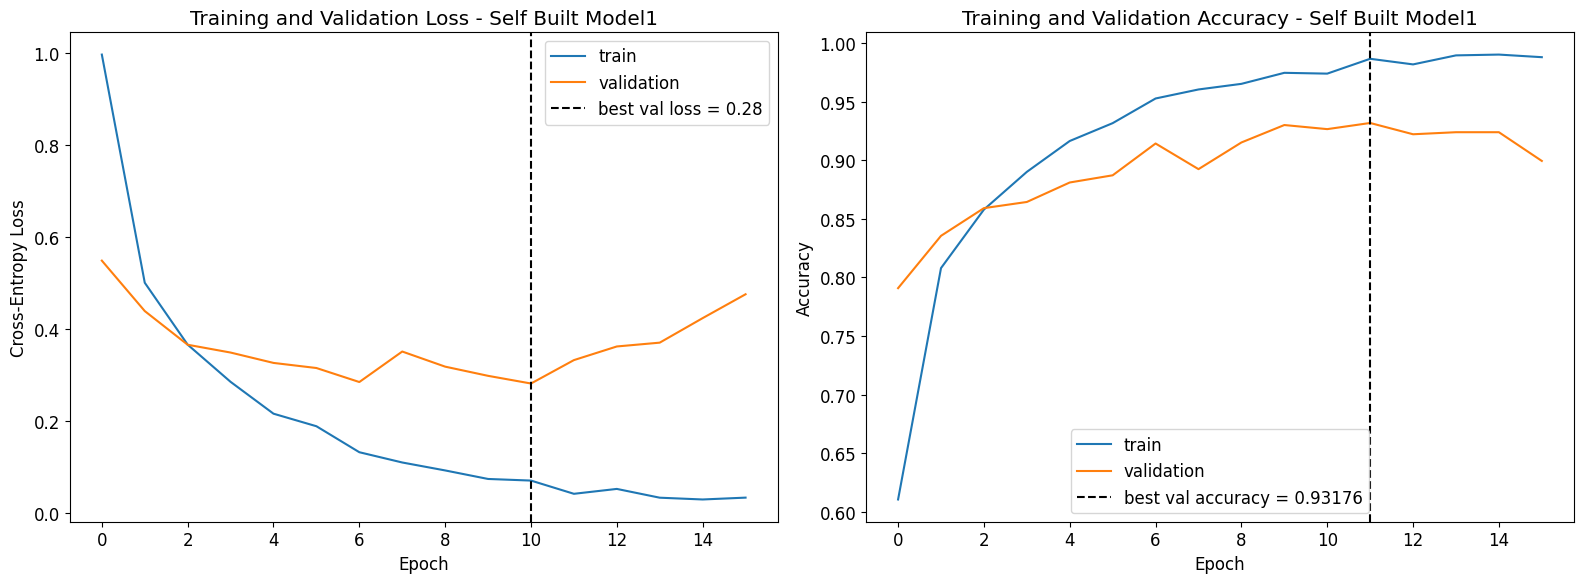

In [ ]:
plot_history(model, "Self Built Model1")

In [ ]:
train_loss, train_acc = model.evaluate(dataset_train)
test_loss, test_acc = model.evaluate(dataset_test)
print(f'The train accuracy is {train_acc}')
print(f'The test accuracy is {test_acc}')

11/11 [==============================] - 1s 85ms/step - loss: 0.3961 - accuracy: 0.9153
The train accuracy is 0.9950419068336487
The test accuracy is 0.9153317809104919


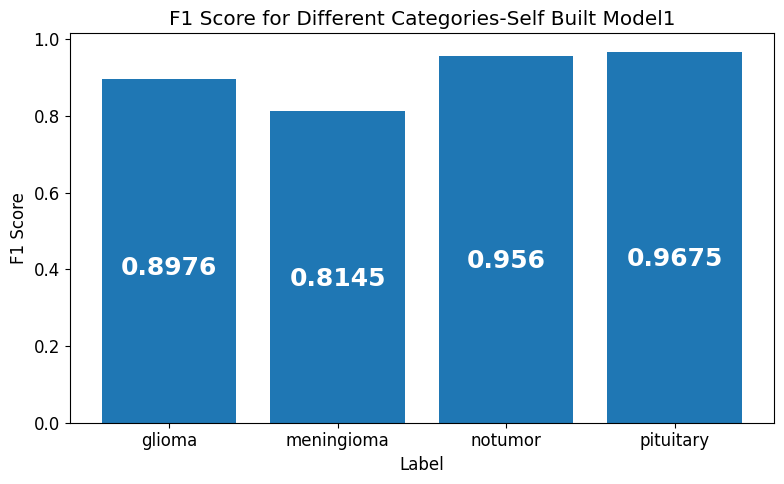

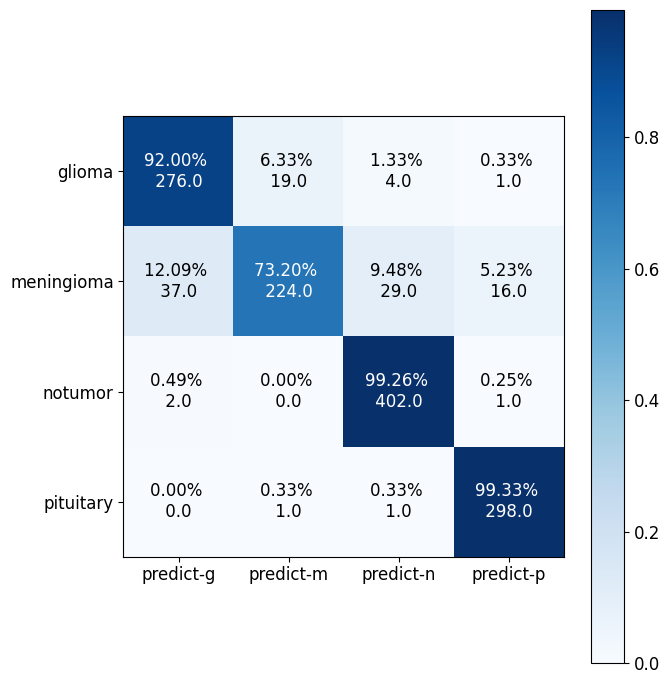

In [ ]:
y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
f1_scores = f1_score(y_test.ravel(), y_pred.ravel(), average=None)

# plot f1 score
plot_f1_score("Self Built Model1", f1_scores)
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model_results=[]
model_results.append(save_accuarcy("Self Built Model1",train_loss, train_acc, test_loss, test_acc, f1_scores))

Model Name: Self Built Model1


## Vgg 16

In [ ]:
vgg16_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in vgg16_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
vgg16_model.layers[-2].trainable = True
vgg16_model.layers[-3].trainable = True
vgg16_model.layers[-4].trainable = True

model = Sequential(name="vgg_16")
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(vgg16_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))

# plot model architecture
keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
# fit model
history = model.fit(dataset_train, epochs=50, batch_size=256,
                   validation_data = dataset_val, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                             

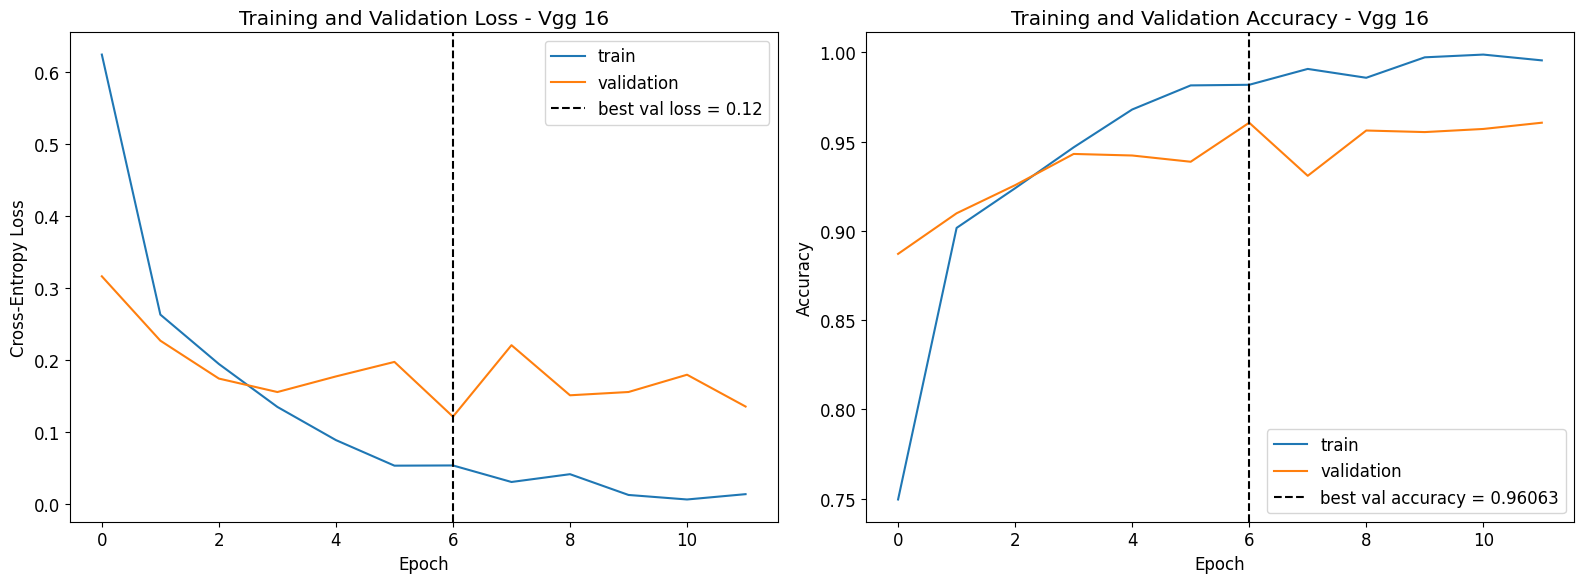

In [ ]:
plot_history(model, "Vgg 16")

In [ ]:
train_loss, train_acc = model.evaluate(dataset_train)
test_loss, test_acc = model.evaluate(dataset_test)
print(f'The train accuracy is {train_acc}')
print(f'The test accuracy is {test_acc}')

11/11 [==============================] - 4s 356ms/step - loss: 0.1296 - accuracy: 0.9680
The train accuracy is 0.9996580481529236
The test accuracy is 0.9679633975028992


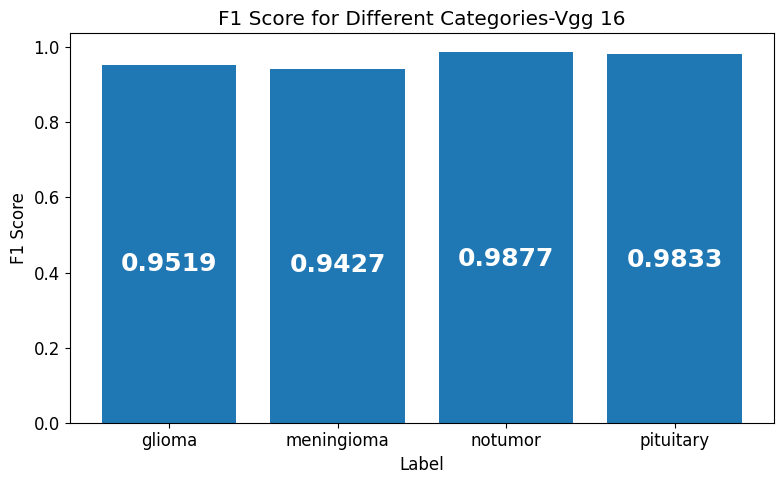

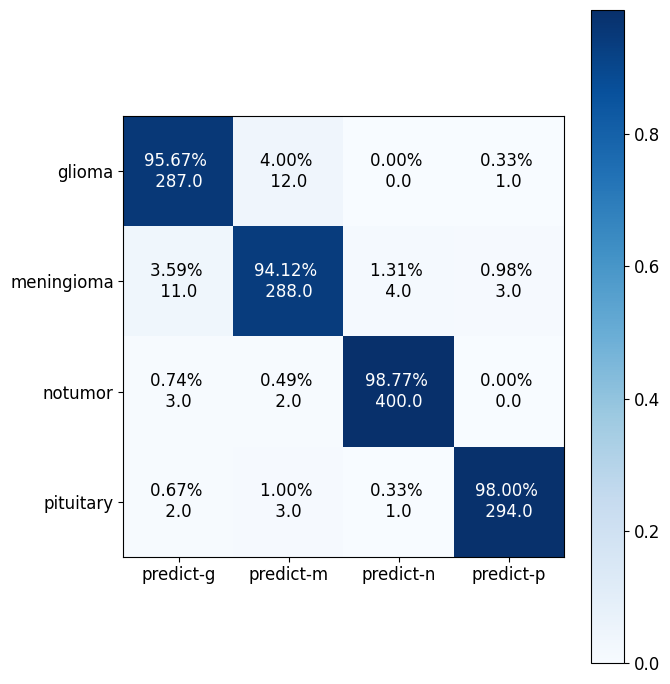

In [ ]:
y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
f1_scores = f1_score(y_test.ravel(), y_pred.ravel(), average=None)

# plot f1 score
plot_f1_score("Vgg 16", f1_scores)
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model_results.append(save_accuarcy("Vgg 16",train_loss, train_acc, test_loss, test_acc, f1_scores))

Model Name: Vgg 16


## ResNet 50

In [ ]:
resnet50_model = ResNet50(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in resnet50_model.layers:
    layer.trainable = False
# Set the last resnet block to trainable
resnet50_model.layers[-2].trainable = True
resnet50_model.layers[-3].trainable = True
resnet50_model.layers[-4].trainable = True

model = Sequential(name="ResNet50")
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(resnet50_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

# plot model architecture
keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
# fit model
history = model.fit(dataset_train, epochs=50, batch_size=256,
                   validation_data = dataset_val, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_10 (Dropout)        (None, 32768)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 31,977,604
Trainable params: 9,444,612
Non-t

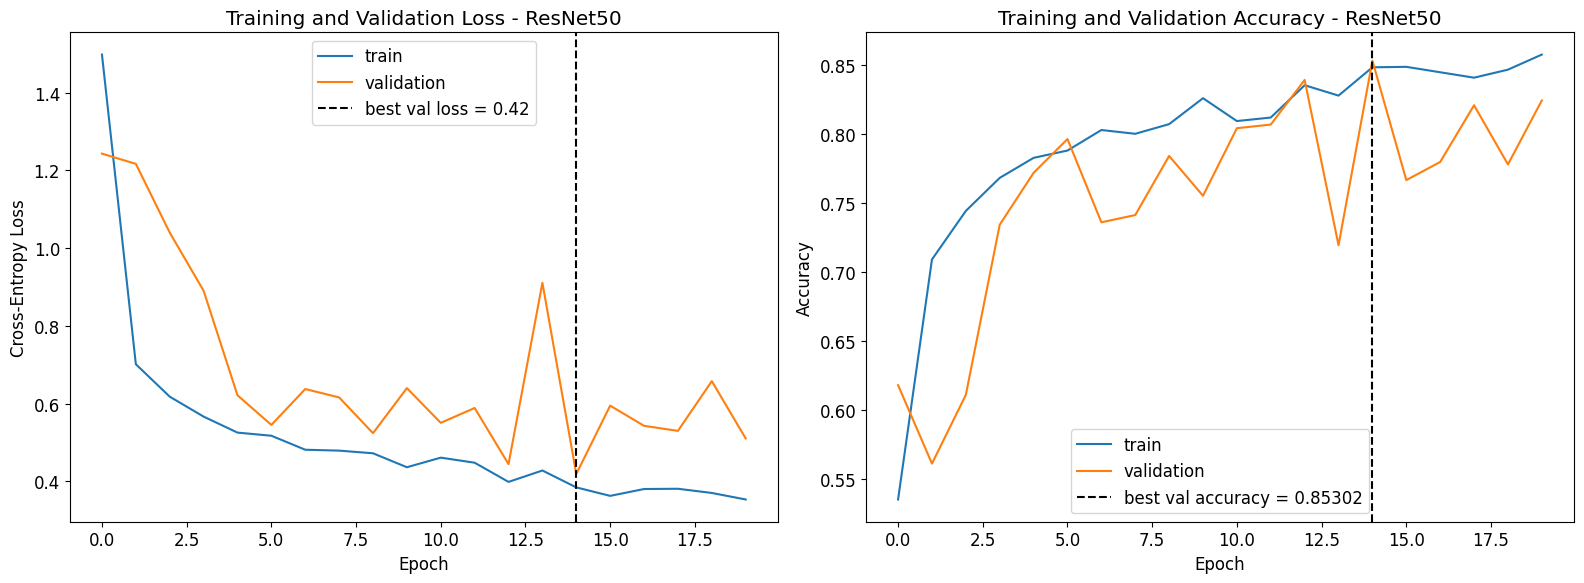

In [ ]:
plot_history(model, "ResNet50")

In [ ]:
train_loss, train_acc = model.evaluate(dataset_train)
test_loss, test_acc = model.evaluate(dataset_test)
print(f'The train accuracy is {train_acc}')
print(f'The test accuracy is {test_acc}')

11/11 [==============================] - 2s 174ms/step - loss: 0.6601 - accuracy: 0.7712
The train accuracy is 0.8664728999137878
The test accuracy is 0.7711670398712158


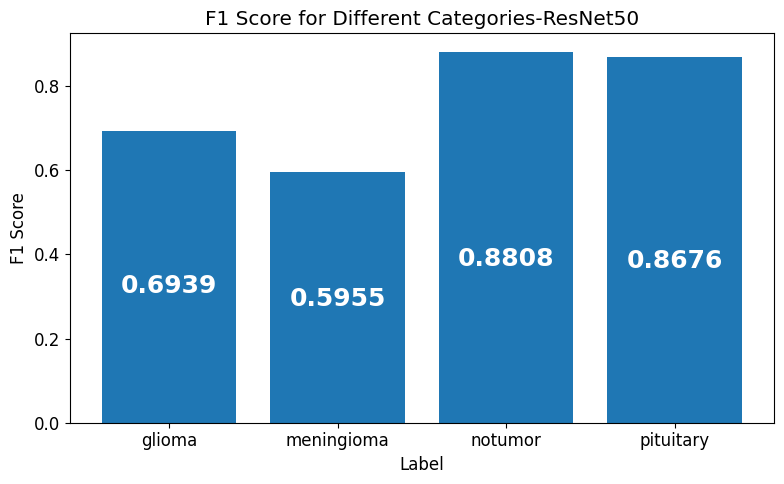

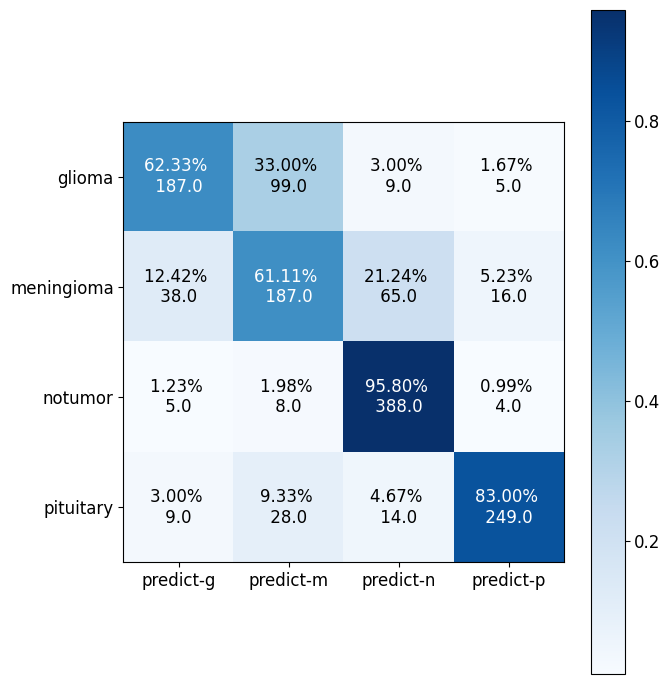

In [ ]:
y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
f1_scores = f1_score(y_test.ravel(), y_pred.ravel(), average=None)

# plot f1 score
plot_f1_score("ResNet50", f1_scores)
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model_results.append(save_accuarcy("ResNet50",train_loss, train_acc, test_loss, test_acc, f1_scores))

Model Name: ResNet50


## GoogleNet

In [ ]:
def inception_block(input_tensor, filters):
    # Branch 1
    branch1 = Conv2D(filters[0], (1,1), activation='relu')(input_tensor)

    # Branch 2
    branch2 = Conv2D(filters[1], (1,1), activation='relu')(input_tensor)
    branch2 = Conv2D(filters[2], (3,3), padding='same', activation='relu')(branch2)

    # Branch 3
    branch3 = Conv2D(filters[3], (1,1), activation='relu')(input_tensor)
    branch3 = Conv2D(filters[4], (5,5), padding='same', activation='relu')(branch3)

    # Branch 4
    branch4 = MaxPool2D((3,3), strides=(1,1), padding='same')(input_tensor)
    branch4 = Conv2D(filters[5], (1,1), activation='relu')(branch4)

    # Concatenate branches
    output_tensor = concatenate([branch1, branch2, branch3, branch4], axis=-1)

    return output_tensor

In [ ]:
def auxiliary_block(input_tensor, aux_name):
    X = AveragePooling2D(pool_size = (5,5), strides = (3,3), padding='same')(input_tensor)
    X = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X)
    X = Flatten()(X)
    X = Dense(1024, activation = 'relu')(X)
    X = Dropout(0.7)(X)
    output_tensor = Dense(4, activation = 'softmax', name = aux_name)(X)

    return output_tensor

In [ ]:
def GoogleNet(input_shape):
    inp = Input(shape=input_shape)

    X = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(inp)
    X = MaxPool2D((3,3), strides=(2,2), padding='same')(X)
    X = Conv2D(64, (1,1), activation='relu')(X)
    X = Conv2D(192, (3,3), padding='same', activation='relu')(X)
    X = MaxPool2D((3,3), strides=(2,2), padding='same')(X)

    # First Inception blocks (x2)
    X = inception_block(X, [64, 96, 128, 16, 32, 32])
    X = inception_block(X, [128, 128, 192, 32, 96, 64])
    X = MaxPool2D((3,3), strides=(2,2), padding='same')(X)

    # Second Inception blocks (x5)
    X = inception_block(X, [192, 96, 208, 16, 48, 64])
    X = inception_block(X, [160, 112, 224, 24, 64, 64])
    X1 = auxiliary_block(X, aux_name = 'aux_output1') # First Auxiliary block

    X = inception_block(X, [128, 128, 256, 24, 64, 64])
    X = inception_block(X, [112, 144, 288, 32, 64, 64])
    X = inception_block(X, [256, 160, 320, 32, 128, 128])
    X2 = auxiliary_block(X, aux_name = 'aux_output2') # Second Auxiliary block

    # Third Inception blocks (x2)
    X = MaxPool2D((3,3), strides=(2,2), padding='same')(X)
    X = inception_block(X, [256, 160, 320, 32, 128, 128])
    X = inception_block(X, [384, 192, 384, 48, 128, 128])
    X = GlobalAvgPool2D()(X)
    X = Dense(4, activation='softmax', name='main_output')(X)
    model = Model(inputs=inp, outputs=[X, X1, X2])

    return model

In [ ]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = GoogleNet(input_shape)

# plot model architecture
keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
# fit model
history = model.fit(dataset_train, epochs=50, batch_size=256,
                   validation_data = dataset_val, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 64, 64)   9472        ['input_9[0][0]']                
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 32, 32, 64)  0           ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 64)   4160        ['max_pooling2d_8[0][0]']    

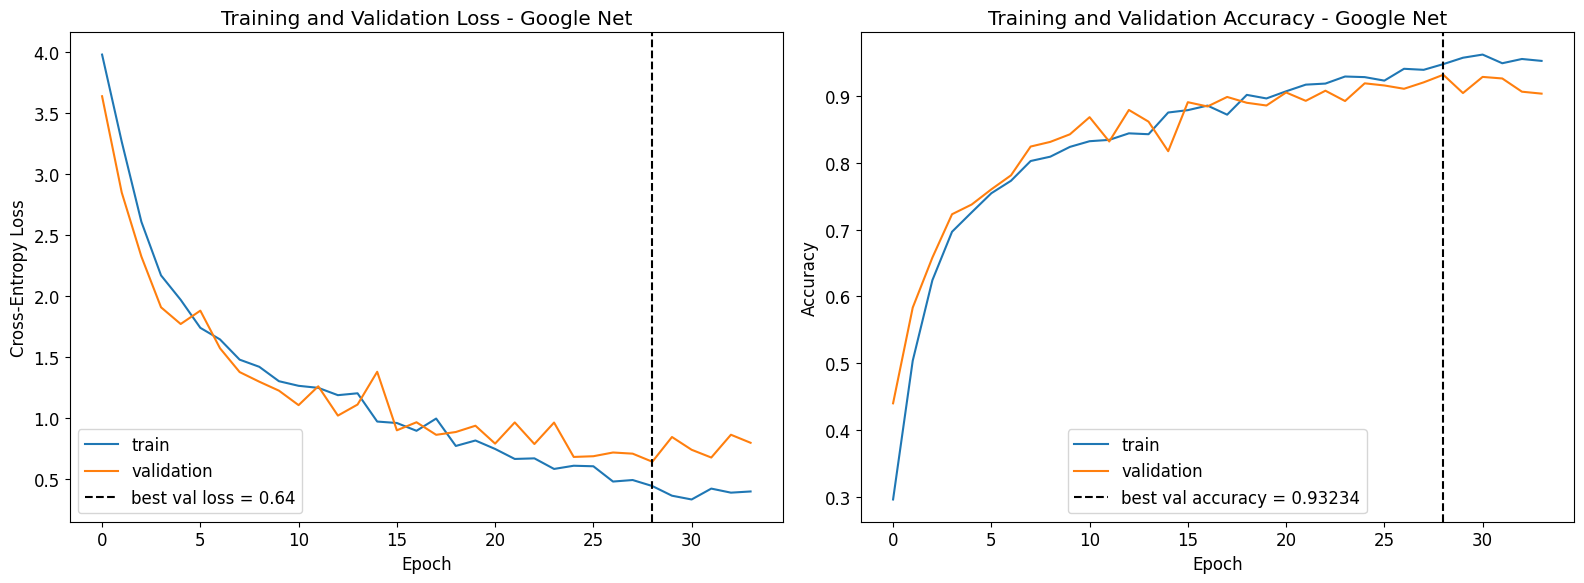

In [ ]:
plot_history(model, "Google Net")

In [ ]:
result = model.evaluate(dataset_train, verbose=0)
if len(model.metrics_names) > 2:
    test_loss_idx = model.metrics_names.index('main_output_loss')
    test_accuracy_idx = model.metrics_names.index('main_output_accuracy')
    train_loss, train_acc = result[test_loss_idx], result[test_accuracy_idx]
else:
    train_loss, train_acc = result

print('The train accuracy is:', round(train_acc, 3))

result = model.evaluate(dataset_test, verbose=0)
if len(model.metrics_names) > 2:
    test_loss_idx = model.metrics_names.index('main_output_loss')
    test_accuracy_idx = model.metrics_names.index('main_output_accuracy')
    test_loss, test_acc = result[test_loss_idx], result[test_accuracy_idx]
else:
    test_loss, test_acc = result

print('The test accuracy is:', round(test_acc, 3))

The train accuracy is: 0.771
The test accuracy is: 0.895


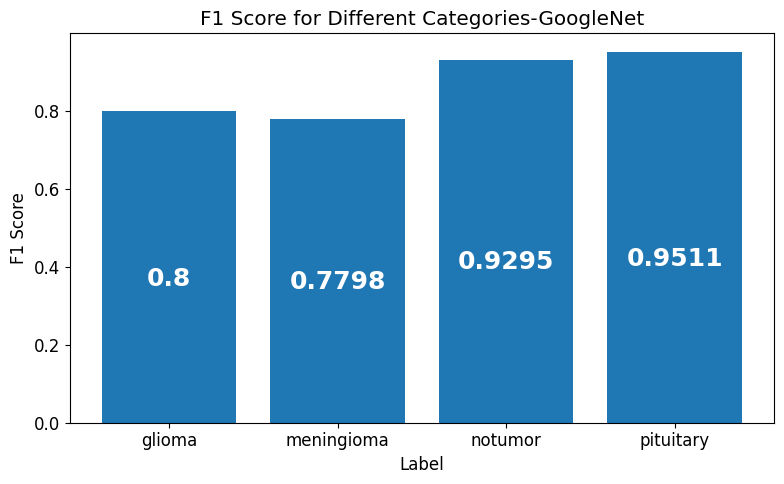

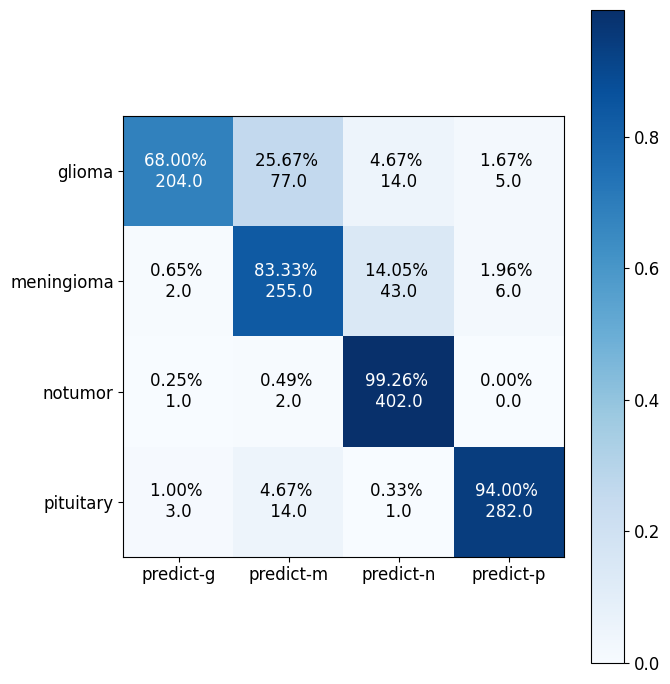

In [ ]:
y_prob = model.predict(X_test, verbose=0)[1]
y_pred = np.argmax(y_prob, axis=-1)
f1_scores = f1_score(y_test.ravel(), y_pred.ravel(), average=None)

# plot f1 score
plot_f1_score("GoogleNet", f1_scores)
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model_results.append(save_accuarcy("GoogleNet",train_loss, train_acc, test_loss, test_acc, f1_scores))

Model Name: GoogleNet


# Create own model

In [ ]:
def Residual(X, num_channels, strides=1, use_1x1conv=False):
    A = Conv2D(num_channels, kernel_size=3, padding='same', strides=strides)(X)
    A = BatchNormalization()(A)
    A = Activation('relu')(A)
    A = Conv2D(num_channels, kernel_size=3, padding='same')(A)
    A = BatchNormalization()(A)
    if use_1x1conv:
        X = Conv2D(num_channels, kernel_size=1, strides=strides)(X)
    A = Add()([A, X]) # Skip connection
    return relu(A)

In [ ]:
def cs109bNet(input_shape):
    inp = Input(shape=input_shape)

    # Now it's your time!
    # Solution key

    X = Conv2D(96, kernel_size=6, strides=2, padding='same')(inp)
    X = BatchNormalization()(X)
    # X = Residual(X, 128, use_1x1conv=True, strides=2)
    X = Conv2D(64, kernel_size=1, strides=2, activation='relu', padding='same')(X)
    X = Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same')(X)
    X = inception_block(X, [64, 96, 128, 16, 32, 32])
    X = inception_block(X, [64, 96, 128, 16, 32, 32])
    X1 = auxiliary_block(X, aux_name = 'aux_output1')
    X = GlobalAvgPool2D()(X)
    X = Dense(4, activation='softmax', name = 'main_output')(X)
    model = Model(inputs=inp, outputs=[X, X1])
    return model

In [ ]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = cs109bNet(input_shape)

# plot model architecture
keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
# fit model
history = model.fit(dataset_train, epochs=50, batch_size=256,
                   validation_data = dataset_val, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_67 (Conv2D)             (None, 64, 64, 96)   10464       ['input_10[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 96)  384         ['conv2d_67[0][0]']              
 alization)                                                                                       
                                                                                            

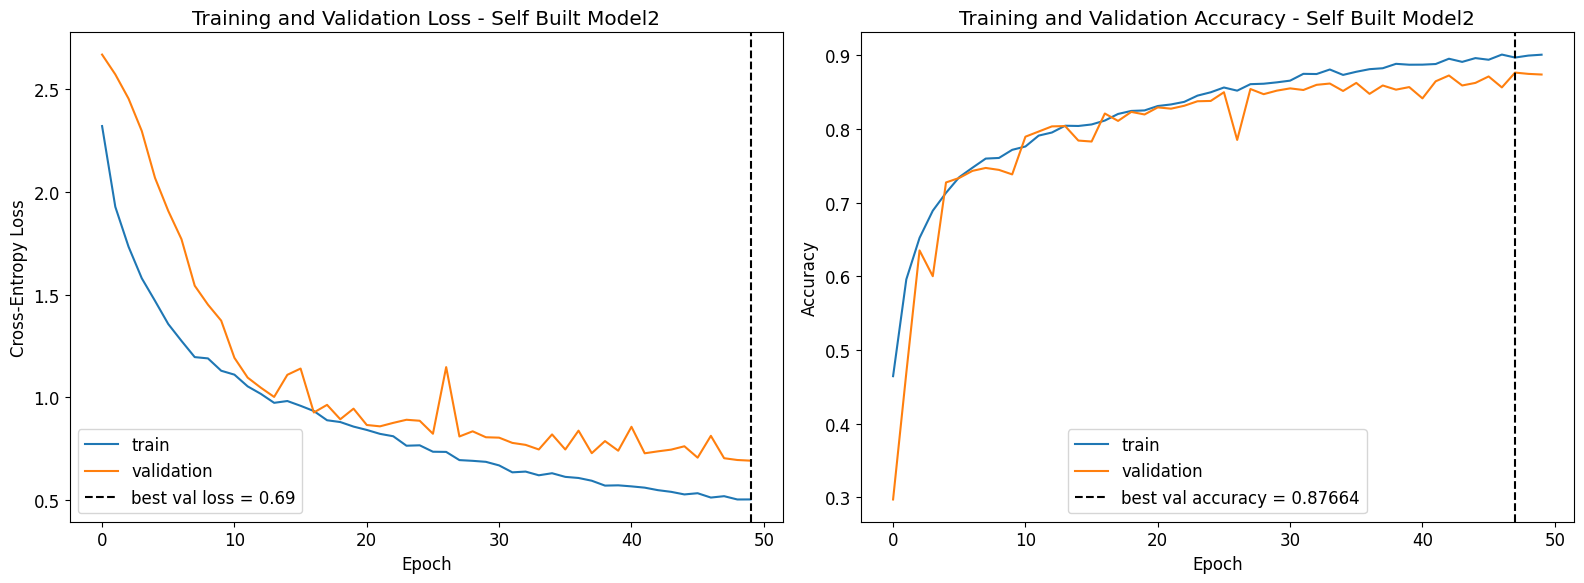

In [ ]:
plot_history(model, "Self Built Model2")

In [ ]:
result = model.evaluate(dataset_train, verbose=0)
if len(model.metrics_names) > 2:
    test_loss_idx = model.metrics_names.index('main_output_loss')
    test_accuracy_idx = model.metrics_names.index('main_output_accuracy')
    train_loss, train_acc = result[test_loss_idx], result[test_accuracy_idx]
else:
    train_loss, train_acc = result

print('The train accuracy is:', round(train_acc, 3))

result = model.evaluate(dataset_test, verbose=0)
if len(model.metrics_names) > 2:
    test_loss_idx = model.metrics_names.index('main_output_loss')
    test_accuracy_idx = model.metrics_names.index('main_output_accuracy')
    test_loss, test_acc = result[test_loss_idx], result[test_accuracy_idx]
else:
    test_loss, test_acc = result

print('The test accuracy is:', round(test_acc, 3))

The train accuracy is: 0.83
The test accuracy is: 0.781


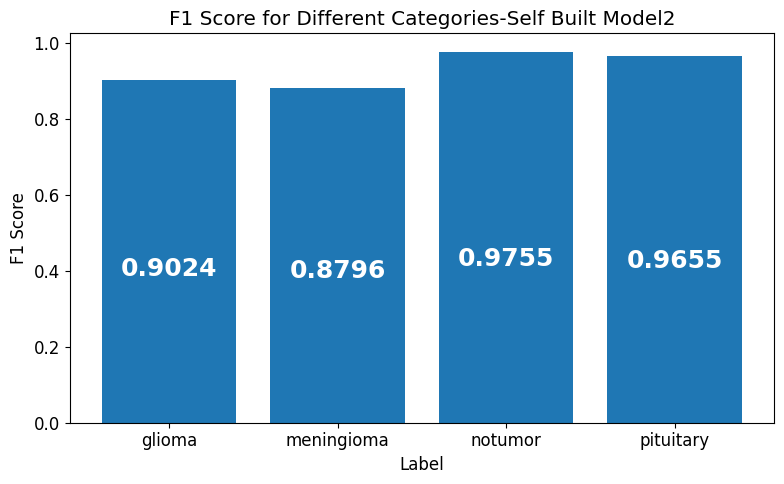

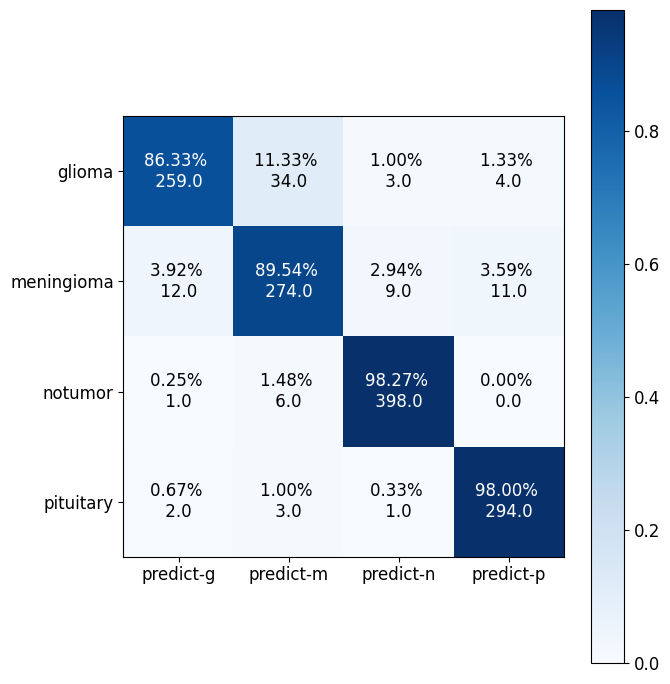

In [ ]:
y_prob = model.predict(X_test, verbose=0)[1]
y_pred = np.argmax(y_prob, axis=-1)
f1_scores = f1_score(y_test.ravel(), y_pred.ravel(), average=None)

# plot f1 score
plot_f1_score("Self Built Model2", f1_scores)
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model_results.append(save_accuarcy("Self Built Model2",train_loss, train_acc, test_loss, test_acc, f1_scores))

Model Name: Self Built Model2


In [ ]:
result_table = pd.DataFrame(model_results)
result_table

,Name,Train Accuracy,Train Loss,Test Accuracy,Test Loss,f1
0,Self Built Model1,0.998803,0.010342,0.932113,0.286858,"[0.9055944055944056, 0.8617886178861789, 0.969..."
1,Vgg 16,0.999487,0.003662,0.970252,0.118359,"[0.9565217391304347, 0.9427168576104746, 0.987..."
2,ResNet50,0.866473,0.318726,0.771167,0.660131,"[0.6938775510204082, 0.5955414012738853, 0.880..."
3,GoogleNet,0.946145,0.149074,0.894737,0.287929,"[0.8, 0.7798165137614679, 0.9294797687861271, ..."
4,Self Built Model2,0.829544,0.411552,0.781083,0.504834,"[0.9024390243902438, 0.8796147672552168, 0.975..."


In [ ]:
result_table = pd.concat([result_table.iloc[:1], result_table.iloc[1:4]]).reset_index(drop = True)
result_table["Name"][0] = "Self Built Model"
result_table["Name"][1] = "VGG16"
result_table

,Name,Train Accuracy,Train Loss,Test Accuracy,Test Loss,f1
0,Self Built Model,0.998803,0.010342,0.932113,0.286858,"[0.9055944055944056, 0.8617886178861789, 0.969..."
1,VGG16,0.999487,0.003662,0.970252,0.118359,"[0.9565217391304347, 0.9427168576104746, 0.987..."
2,ResNet50,0.866473,0.318726,0.771167,0.660131,"[0.6938775510204082, 0.5955414012738853, 0.880..."
3,GoogleNet,0.946145,0.149074,0.894737,0.287929,"[0.8, 0.7798165137614679, 0.9294797687861271, ..."


In [ ]:
model_results

[{'Name': 'Self Built Model1',
  'Train Accuracy': 0.9988031983375549,
  'Train Loss': 0.01034179050475359,
  'Test Accuracy': 0.9321128726005554,
  'Test Loss': 0.2868582010269165,
  'f1': array([0.90559441, 0.86178862, 0.96969697, 0.97704918])},
 {'Name': 'Vgg 16',
  'Train Accuracy': 0.9994871020317078,
  'Train Loss': 0.003662214381620288,
  'Test Accuracy': 0.970251739025116,
  'Test Loss': 0.11835870146751404,
  'f1': array([0.95652174, 0.94271686, 0.98768473, 0.98835275])},
 {'Name': 'ResNet50',
  'Train Accuracy': 0.8664728999137878,
  'Train Loss': 0.31872639060020447,
  'Test Accuracy': 0.7711670398712158,
  'Test Loss': 0.6601311564445496,
  'f1': array([0.69387755, 0.5955414 , 0.88081725, 0.86759582])},
 {'Name': 'GoogleNet',
  'Train Accuracy': 0.9461446404457092,
  'Train Loss': 0.14907440543174744,
  'Test Accuracy': 0.8947368264198303,
  'Test Loss': 0.2879287302494049,
  'f1': array([0.8       , 0.77981651, 0.92947977, 0.95109612])},
 {'Name': 'Self Built Model2',
  'T

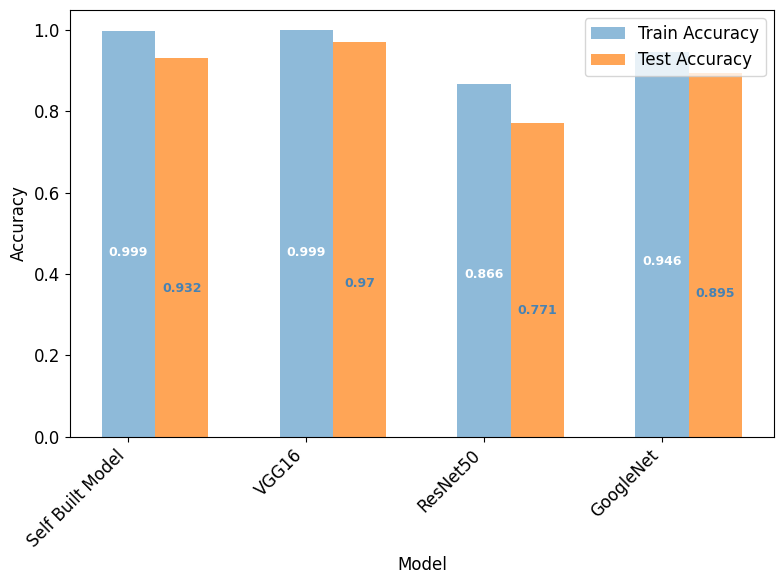

In [ ]:
x_labels = result_table['Name']

# Create the bar plot
width = 0.3
plt.figure(figsize=(8, 6))
plt.bar(np.arange(4), result_table['Train Accuracy'], width, align = "center", alpha = 0.5,  label='Train Accuracy')
for i in range(4):
  plt.text(i, result_table['Train Accuracy'][i]/2.5, str(np.round(result_table['Train Accuracy'][i], 3))+'\n',
              ha='center', va='bottom', color='white', weight='bold', fontsize = 9)
plt.bar(np.arange(4) + width, result_table['Test Accuracy'], width, align = "center", alpha = 0.7, label='Test Accuracy')
for i in range(4):
  plt.text(i + width, result_table['Test Accuracy'][i]/3, str(np.round(result_table['Test Accuracy'][i], 3))+'\n',
              ha='center', va='bottom', color='steelblue', weight='bold', fontsize = 9)
plt.legend(loc='upper right')
plt.xticks(np.arange(4), x_labels, rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.tight_layout()

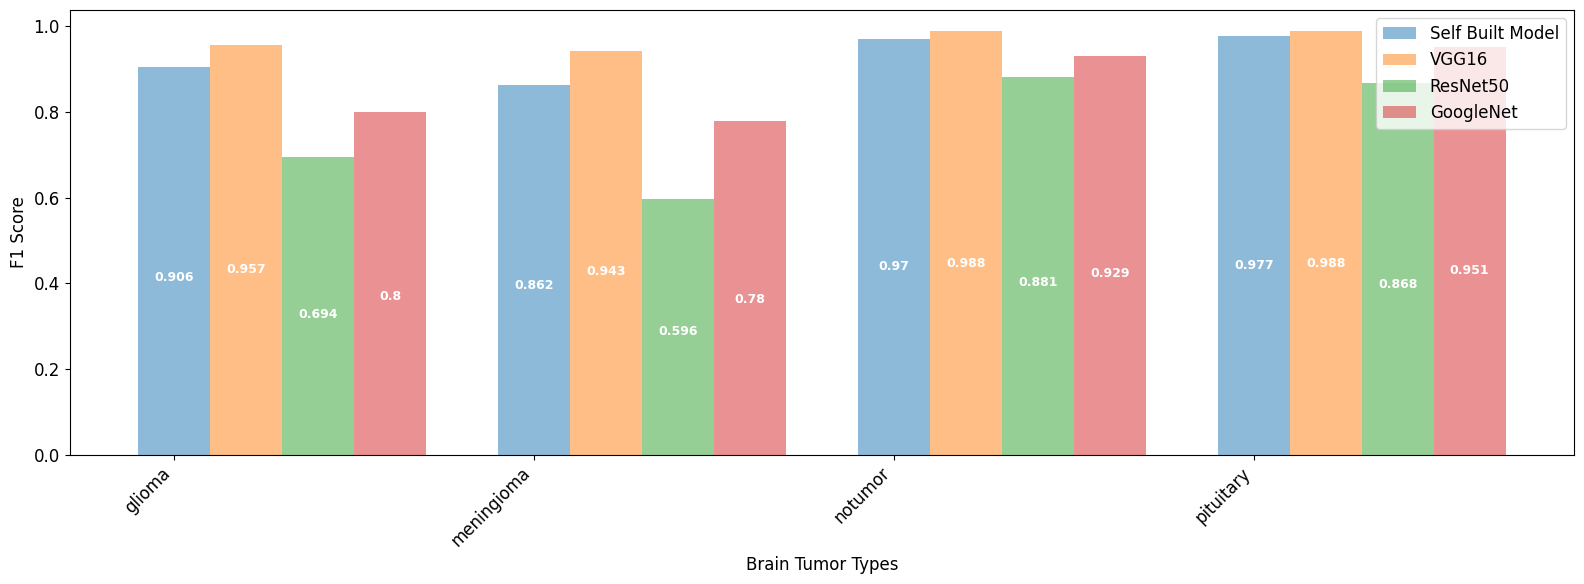

In [ ]:
x_labels = result_table['Name']

# Create the bar plot
width = 0
plt.figure(figsize=(16, 6))
for i in range(4):
  plt.bar(np.arange(4) + width, result_table['f1'][i], 0.2, align = "center", alpha = 0.5,  label=x_labels[i])
  for j in range(4):
    plt.text(j + width, result_table['f1'][i][j]/2.5, str(np.round(result_table['f1'][i][j], 3))+'\n',
                ha='center', va='bottom', color='white', weight='bold', fontsize = 9)
  width += 0.2

plt.legend(loc='upper right')
plt.xticks(np.arange(4), labels, rotation=45, ha='right')
plt.xlabel('Brain Tumor Types')
plt.ylabel('F1 Score')

plt.tight_layout()